# MACHINE LEARNING PROJECT
## Housing Prices
https://www.dropbox.com/s/zxv6ujxl8kmijfb/cal-housing.csv?dl=0

Implement from scratch the ridge regression algorithm for regression with square loss (lecture notes on “Linear prediction”). It is OK to use libraries for linear algebra and basic data manipulation (e.g., Numpy and Pandas). Apply the algorithm to the prediction of the label medianHouseValue in this dataset. Study the dependence of the cross-validated risk estimate on the parameter alpha of ridge regression. Try using PCA to improve the risk estimate. Optionally, use nested cross-validated risk estimates to remove the need of choosing the parameter.

To do list:
- Import cell
- Check ridge
- Further exploration



In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
orig_df = pd.read_csv("cal-housing.csv")

In [3]:
orig_df.head(10)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY
5,-122.25,37.85,52.0,919.0,213.0,413.0,193.0,4.0368,269700.0,NEAR BAY
6,-122.25,37.84,52.0,2535.0,489.0,1094.0,514.0,3.6591,299200.0,NEAR BAY
7,-122.25,37.84,52.0,3104.0,687.0,1157.0,647.0,3.1200,241400.0,NEAR BAY
8,-122.26,37.84,42.0,2555.0,665.0,1206.0,595.0,2.0804,226700.0,NEAR BAY
9,-122.25,37.84,52.0,3549.0,707.0,1551.0,714.0,3.6912,261100.0,NEAR BAY


array([[<AxesSubplot:title={'center':'longitude'}>,
        <AxesSubplot:title={'center':'latitude'}>,
        <AxesSubplot:title={'center':'housing_median_age'}>],
       [<AxesSubplot:title={'center':'total_rooms'}>,
        <AxesSubplot:title={'center':'total_bedrooms'}>,
        <AxesSubplot:title={'center':'population'}>],
       [<AxesSubplot:title={'center':'households'}>,
        <AxesSubplot:title={'center':'median_income'}>,
        <AxesSubplot:title={'center':'median_house_value'}>]],
      dtype=object)

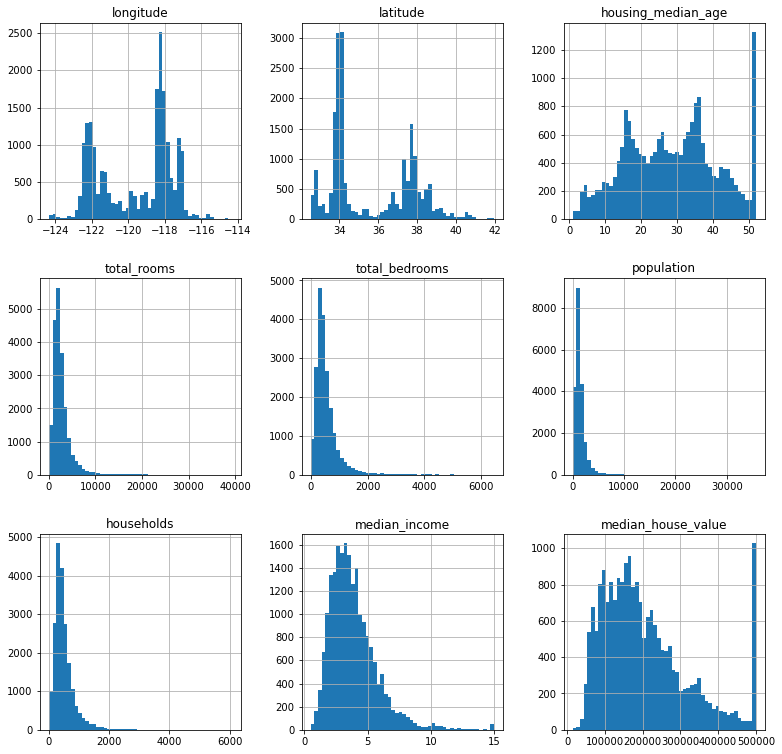

In [4]:
orig_df.hist(bins=50, figsize=(13, 13))

### Missing Values

In [5]:
orig_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


*Total_bedrooms* variable contains 20433 instead of 20640 values: we have 207 missing values.
We can use different techniques to solve this problem: one of those is to replace missing values with the average value of the column.

In [6]:
corr_df = orig_df.copy()

In [7]:
corr_df['total_bedrooms'].fillna(corr_df['total_bedrooms'].mean(), inplace=True)

In [8]:
print(corr_df['total_bedrooms'].mean(), orig_df['total_bedrooms'].mean())

537.8705525375639 537.8705525375618


### Ocean_proximity variable

Between the variables below, we do not see ocean_proximity, because it is categorical. To be used in our model, we need to solve this situation.

In [9]:
corr_df.ocean_proximity.describe()

count         20640
unique            5
top       <1H OCEAN
freq           9136
Name: ocean_proximity, dtype: object

In [10]:
import numpy as np
corr_df.ocean_proximity.value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

Since __ISLAND__ category has such a different numerousness, we decided to remove it from the possible values of the *ocean_proximity* variable.

In [11]:
corr_df = corr_df.loc[corr_df["ocean_proximity"] != "ISLAND"]

In [12]:
labels, uniques = pd.factorize(['<1H OCEAN', 'INLAND', 'NEAR OCEAN','NEAR BAY' ])
labels

array([0, 1, 2, 3], dtype=int64)

In [13]:
ocean_mapper = {
    'NEAR BAY': 0,
    'NEAR OCEAN': 1,
    '<1H OCEAN' : 2,
    'INLAND' : 3
    }

In [14]:
corr_df.replace({'ocean_proximity': ocean_mapper}, inplace=True) 

In [15]:
corr_df.ocean_proximity.value_counts()

2    9136
3    6551
1    2658
0    2290
Name: ocean_proximity, dtype: int64

# Data Exploration

We extract from the dataset the column defining the house value *median_house_value* and we use it as the dependent variable *y*.

In [16]:
n_corr_df = corr_df.copy()

In [17]:
X, y = n_corr_df.drop(columns=['median_house_value']), corr_df['median_house_value']

In [18]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler() #standardize -1,1
X_scaled = scaler.fit_transform(X)

In [19]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

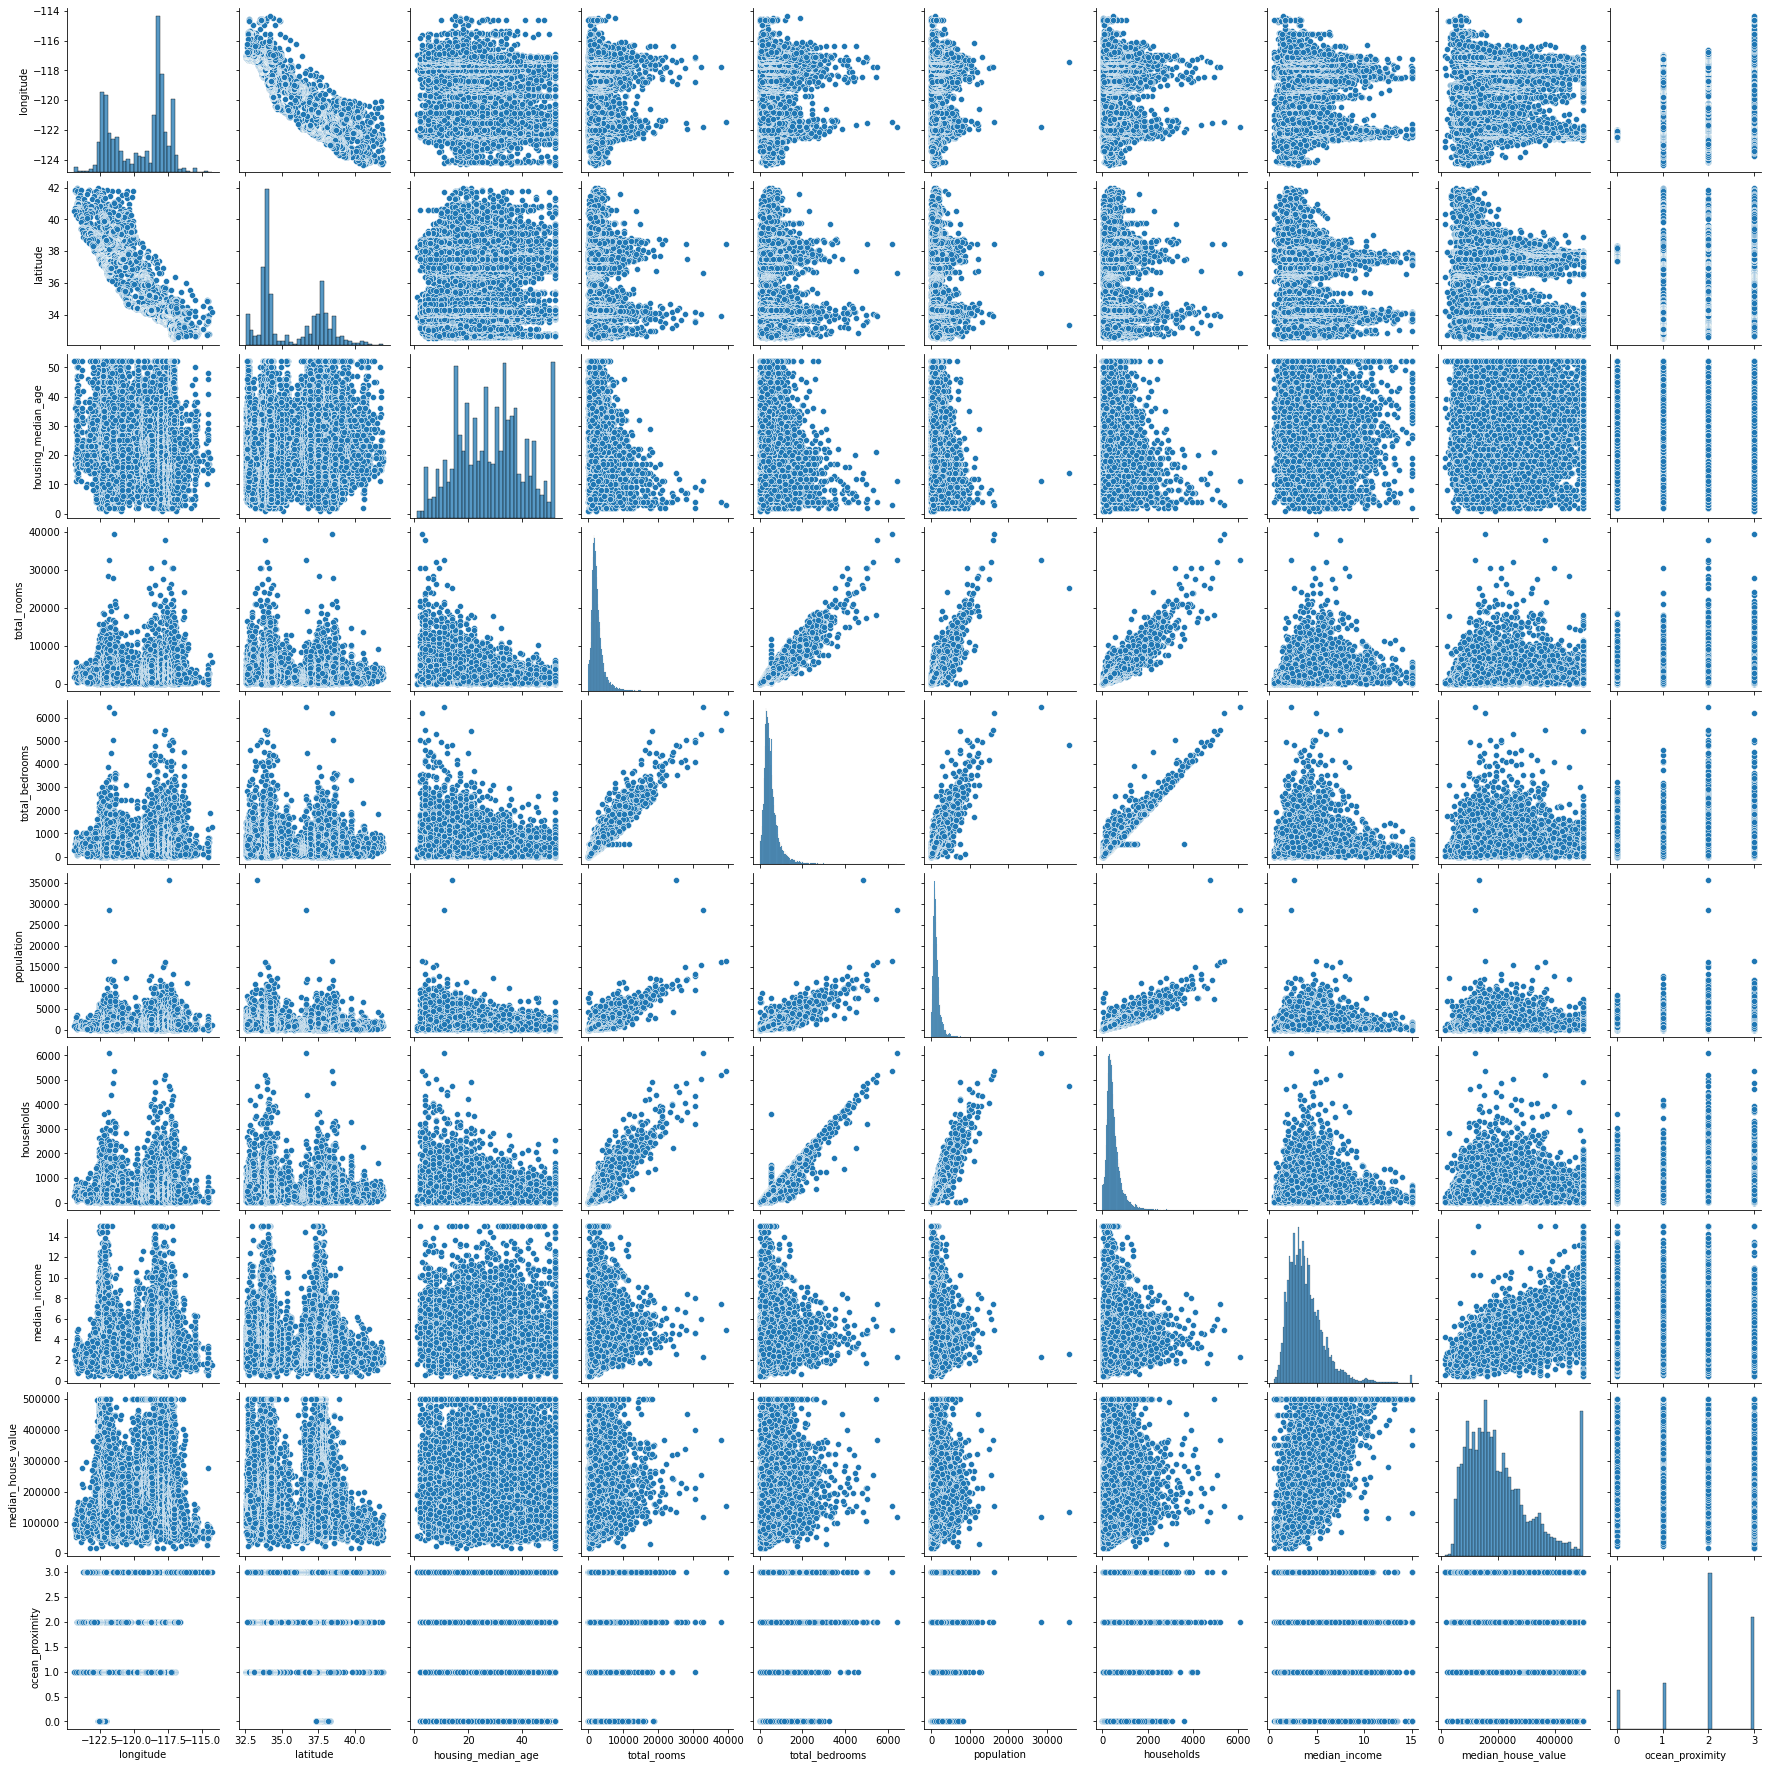

In [20]:
import seaborn as sns
sns.pairplot(corr_df)

In [21]:
corr_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20635 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20635 non-null  float64
 1   latitude            20635 non-null  float64
 2   housing_median_age  20635 non-null  float64
 3   total_rooms         20635 non-null  float64
 4   total_bedrooms      20635 non-null  float64
 5   population          20635 non-null  float64
 6   households          20635 non-null  float64
 7   median_income       20635 non-null  float64
 8   median_house_value  20635 non-null  float64
 9   ocean_proximity     20635 non-null  int64  
dtypes: float64(9), int64(1)
memory usage: 1.7 MB


In [22]:
corr_df.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
count,20635.000000,20635.000000,20635.000000,20635.000000,20635.000000,20635.000000,20635.000000,20635.000000,20635.000000,20635.000000
mean,-119.569999,35.632412,28.636152,2636.020208,537.899016,1425.660286,499.593700,3.870944,206813.756288,1.966707
std,2.003685,2.135918,12.583924,2181.794772,419.306772,1132.530137,382.357072,1.899961,115372.499511,0.942932
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000,0.000000
25%,-121.800000,33.930000,18.000000,1448.000000,297.000000,787.000000,280.000000,2.563100,119600.000000,2.000000
50%,-118.500000,34.260000,29.000000,2127.000000,438.000000,1166.000000,409.000000,3.535200,179700.000000,2.000000
75%,-118.010000,37.710000,37.000000,3148.000000,644.000000,1725.000000,605.000000,4.743700,264700.000000,3.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000,3.000000


<Figure size 432x288 with 0 Axes>

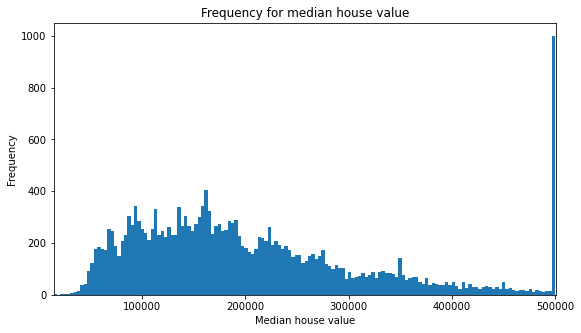

count     20635.000000
mean     206813.756288
std      115372.499511
min       14999.000000
25%      119600.000000
50%      179700.000000
75%      264700.000000
max      500001.000000
Name: median_house_value, dtype: float64

In [23]:
# Variable HOUSE VALUE
fig = plt.figure()
plt.figure(figsize=(9,5))
plt.hist(y, bins= 150)
plt.xlim(15000,500500)
plt.title('Frequency for median house value')
plt.xlabel("Median house value")
plt.ylabel("Frequency")
#plt.grid(True)
fig.savefig("images\Frequency for median house value.png")
plt.show()

<Figure size 432x288 with 0 Axes>

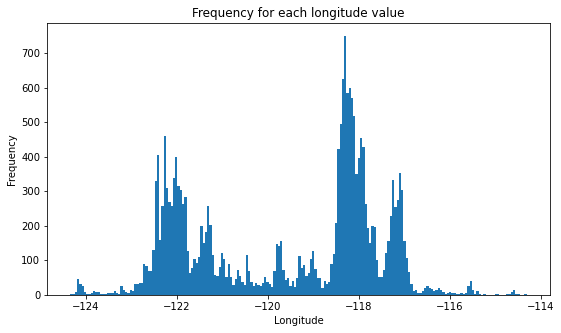

count    20635.000000
mean      -119.569999
std          2.003685
min       -124.350000
25%       -121.800000
50%       -118.500000
75%       -118.010000
max       -114.310000
Name: longitude, dtype: float64

In [24]:
fig = plt.figure()
plt.figure(figsize=(9,5))
plt.hist(corr_df.longitude.values, bins= 200)
plt.title('Frequency for each longitude value')
plt.xlabel("Longitude")
plt.ylabel("Frequency")
#plt.grid(True)
fig.savefig("images\Frequency for each longitude value.png")
plt.show()

<Figure size 432x288 with 0 Axes>

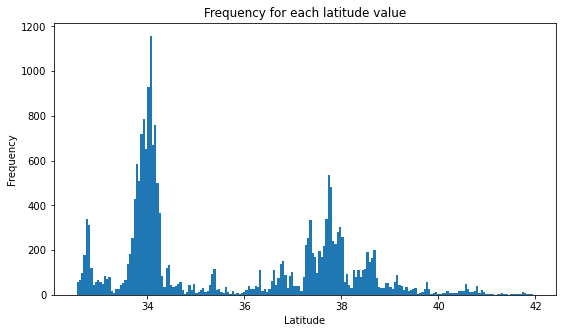

In [25]:
fig = plt.figure()
plt.figure(figsize=(9,5))
plt.hist(corr_df.latitude.values, bins= 200)
plt.title('Frequency for each latitude value')
plt.xlabel("Latitude")
plt.ylabel("Frequency")
#plt.grid(True)
fig.savefig("images\Frequency for each latitude value.png")
plt.show()

<Figure size 432x288 with 0 Axes>

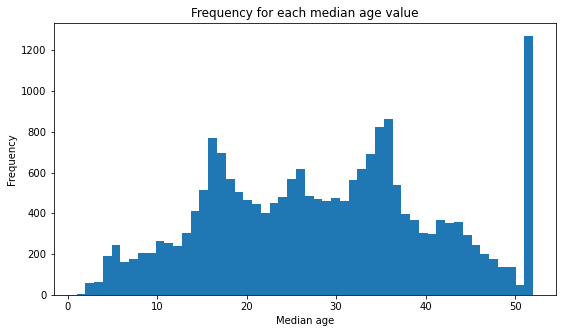

In [26]:
fig = plt.figure()
plt.figure(figsize=(9,5))
plt.hist(corr_df.housing_median_age.values, bins= 52) #has only 52 unique values
plt.title('Frequency for each median age value')
plt.xlabel("Median age")
plt.ylabel("Frequency")
#plt.grid(True)
fig.savefig("images\Frequency for each Median age value.png")
plt.show()

In [27]:
unique_list = []
def unique(list1):    
    for x in list1:
        if x not in unique_list:
            unique_list.append(x)
        
unique(corr_df.housing_median_age)
unique_list
len(unique_list)

52

<Figure size 432x288 with 0 Axes>

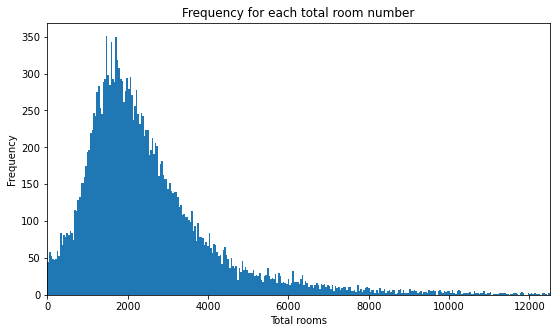

In [28]:
fig = plt.figure()
plt.figure(figsize=(9,5))
plt.hist(corr_df.total_rooms.values, bins= 1000)
plt.xlim(0,12500)
plt.title('Frequency for each total room number')
plt.xlabel("Total rooms")
plt.ylabel("Frequency")
#plt.grid(True)
fig.savefig("images\Frequency for each total room number.png")
plt.show()

<Figure size 432x288 with 0 Axes>

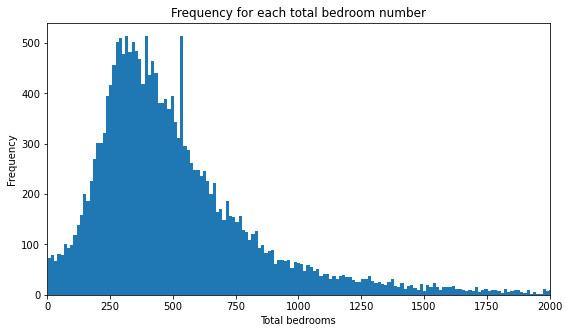

In [29]:
fig = plt.figure()
plt.figure(figsize=(9,5))
plt.hist(corr_df.total_bedrooms.values, bins= 500)
plt.xlim(0,2000)
plt.title('Frequency for each total bedroom number')
plt.xlabel("Total bedrooms")
plt.ylabel("Frequency")
#plt.grid(True)
fig.savefig("images\Frequency for each total bedroom number.png")
plt.show()

<Figure size 432x288 with 0 Axes>

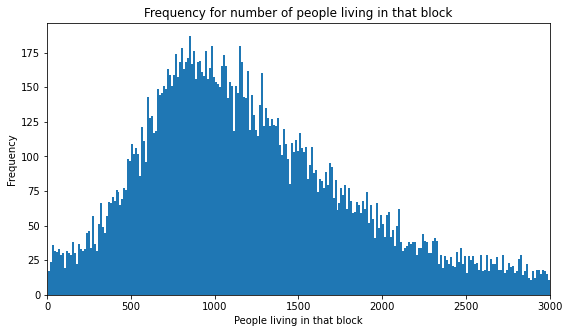

In [30]:
fig = plt.figure()
plt.figure(figsize=(9,5))
plt.hist(corr_df.population.values, bins= 3000)
plt.xlim(0,3000)
plt.title('Frequency for number of people living in that block')
plt.xlabel("People living in that block")
plt.ylabel("Frequency")
#plt.grid(True)
fig.savefig("images\Frequency for population.png")
plt.show()

<Figure size 432x288 with 0 Axes>

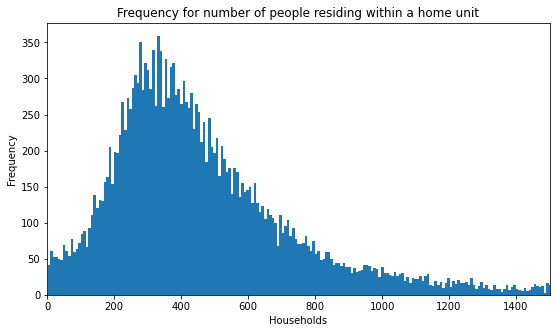

In [31]:
fig = plt.figure()
plt.figure(figsize=(9,5))
plt.hist(corr_df.households.values, bins= 800)
plt.xlim(0,1500)
plt.title('Frequency for number of people residing within a home unit')
plt.xlabel("Households")
plt.ylabel("Frequency")
#plt.grid(True)
fig.savefig("images\Frequency for households.png")
plt.show()

<Figure size 432x288 with 0 Axes>

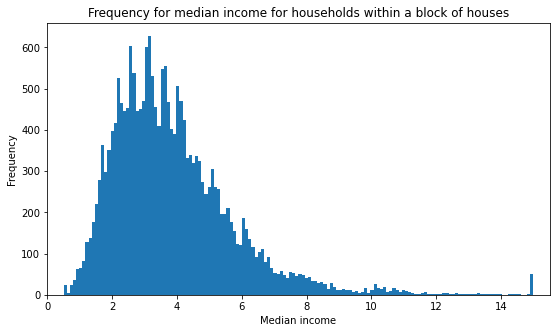

In [32]:
fig = plt.figure()
plt.figure(figsize=(9,5))
plt.hist(corr_df.median_income.values, bins= 150)
plt.xlim(0,15.5)
plt.title('Frequency for median income for households within a block of houses')
plt.xlabel("Median income")
plt.ylabel("Frequency")
#plt.grid(True)
fig.savefig("images\Frequency for median income.png")
plt.show()

<AxesSubplot:xlabel='longitude', ylabel='latitude'>

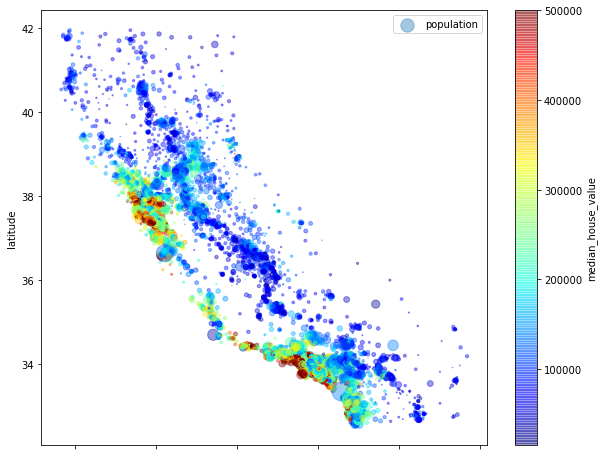

In [33]:
long_lat_value = corr_df.plot(kind='scatter', x='longitude', y='latitude', alpha=0.4, 
    s=corr_df['population']/100, label='population', figsize=(10,8), 
    c='median_house_value', cmap=plt.get_cmap('jet'), colorbar=True)
long_lat_value.figure.savefig("images\long_lat_value.png")
long_lat_value

In [36]:
def fit(X, y, alpha):
    w = np.zeros(X.shape[1])
    w = 2 * X.T * (X * w - y) + 2 * alpha * w

## RIDGE

In [37]:
from numpy import mean
from numpy import std
from numpy import absolute
from pandas import read_csv
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.linear_model import Ridge

# SITO https://machinelearningmastery.com/ridge-regression-with-python/

In [38]:
# bisogna prima normalizzare i dati??
data = corr_df.values
X, y = data[:, :-1], data[:, -1]
# define model 
model = Ridge(alpha=1)
# define model evaluation method
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate model
scores = cross_val_score(model, X, y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
# force scores to be positive
scores = absolute(scores)
print('Mean MAE: %.3f (%.3f)' % (mean(scores), std(scores)))

Mean MAE: 0.509 (0.008)


# CODING http://localhost:8889/notebooks/OneDrive%20-%20Universit%C3%A0%20degli%20Studi%20di%20Milano/UNIVERSITA/DSE/Esami%20fatti/CODING/II%20modulo%20Coding/CDS-master1/CDS-master/Part_10.ipynb

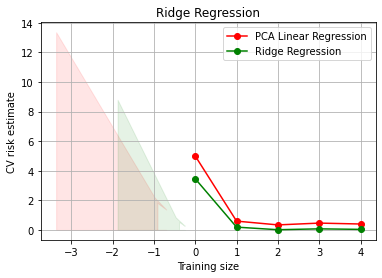

In [39]:
# aree grafico non funzionano
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

import seaborn as sns

from sklearn import decomposition
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.model_selection import train_test_split, learning_curve, cross_val_score, validation_curve, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.datasets import make_regression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

#from auxCode import *
%matplotlib inline
pca = decomposition.PCA(n_components=6)
pca.fit(X)
X_pca = pca.transform(X)

learner = LinearRegression(normalize=True)
RMS = 'neg_mean_squared_error'

lin_reg = LinearRegression(normalize=True)

l_train_size, l_train_score, l_val_score = learning_curve(lin_reg, X_pca, y, cv=5)
r_train_size, r_train_score, r_val_score = learning_curve(Ridge(normalize=True), X_pca, y,  cv=5)
plt.title('Ridge Regression')
l_val_score_mean = -np.mean(l_val_score, axis=1)
l_val_score_std = np.std(l_val_score, axis=1)
r_val_score_mean = -np.mean(r_val_score, axis=1)
r_val_score_std = np.std(r_val_score, axis=1)
plt.grid()
plt.fill_between(l_val_score_mean - l_val_score_std, l_val_score_mean + l_val_score_std, alpha=0.1,color="r")
plt.fill_between(r_val_score_mean - r_val_score_std,r_val_score_mean + r_val_score_std, alpha=0.1, color="g")
plt.plot(l_val_score_mean, 'o-', color="r",label="PCA Linear Regression")
plt.plot(r_val_score_mean, 'o-', color="g",label="Ridge Regression")
plt.legend()
plt.xlabel('Training size')
plt.ylabel('CV risk estimate')
plt.show()

# SITO https://www.pluralsight.com/guides/linear-lasso-ridge-regression-scikit-learn

In [40]:
import pandas as pd
import numpy as np
from sklearn import model_selection
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from math import sqrt
target_column = ['median_house_value'] 
predictors = list(set(list(corr_df.columns))-set(target_column))
corr_df[predictors] = corr_df[predictors]/corr_df[predictors].max()
print(corr_df.describe())
X = corr_df[predictors].values
y = corr_df[target_column].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=40)
print(X_train.shape)
print(X_test.shape)

          longitude      latitude  housing_median_age   total_rooms  \
count  20635.000000  20635.000000        20635.000000  20635.000000   
mean       1.046015      0.849402            0.550695      0.067040   
std        0.017529      0.050916            0.241999      0.055488   
min        1.000000      0.775685            0.019231      0.000051   
25%        1.032368      0.808820            0.346154      0.036826   
50%        1.036655      0.816687            0.557692      0.054095   
75%        1.065524      0.898927            0.711538      0.080061   
max        1.087831      1.000000            1.000000      1.000000   

       total_bedrooms    population    households  median_income  \
count    20635.000000  20635.000000  20635.000000   20635.000000   
mean         0.083460      0.039955      0.082143       0.258061   
std          0.065059      0.031740      0.062867       0.126663   
min          0.000155      0.000084      0.000164       0.033326   
25%          0.04608

In [41]:
#alpha_vals = np.linspace(0.01,1.0,2)
#rr = Ridge(alpha_vals)
rr = Ridge(alpha=1)
rr.fit(X_train, y_train) 
pred_train_rr= rr.predict(X_train)
print('RMSE train: %.3f' % np.sqrt(mean_squared_error(y_train,pred_train_rr)))
print('R2 train: %.3f' % r2_score(y_train, pred_train_rr))

pred_test_rr= rr.predict(X_test)
print('RMSE test: %.3f' % (np.sqrt(mean_squared_error(y_test,pred_test_rr))))
print('R2 test: %.3f' %r2_score(y_test, pred_test_rr))

RMSE train: 71251.074
R2 train: 0.620
RMSE test: 70504.841
R2 test: 0.624


In [42]:
# GET INSPIRED https://rstudio-pubs-static.s3.amazonaws.com/520912_bbd05dad7ffe4eb08ab51ee2c5bd90bb.html